<a href="https://colab.research.google.com/github/dshenker/ML2020FinalProject/blob/main/Final_Expression_CNN_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from skimage import transform
from torchvision import models

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
#define dataset class
class Dataset(Dataset):
    
    def __init__(self, file_path):
        data = np.load(file_path)
        #scaling images to 0 - 1
        self.features = data["x"]
        self.features = self.features.astype(np.float32) / 255.0
        
        #going to try and normalize
        sum_m,sum_std = 0,0
        for img in self.features:
          sum_m += img.mean()
          sum_std += img.std()
        m = sum_m / self.features.shape[0]
        s = sum_std / self.features.shape[0]

        #Option to resize and modify next portions a bit, here we just duplicate to 
        #three channels
        imgs_arr = []
        for img in self.features:
        #   new_im = transform.resize(img,(224,224))
        #   #each needs three "channels"
           imgs_arr.append([img,img,img])
        self.features = np.array(imgs_arr)

        #printing finished shape
        print(self.features.shape)

        #Finishing normalization
        self.features = (self.features - m) / s
        self.labels = data["y"]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        feature = np.expand_dims(self.features[index,:,:],0)
        label = self.labels[index]
        return feature, label

In [5]:
from google.colab import drive
drive.mount('/content/drive') #May need to add image_dataset.npz as shortcut to your "MyDrive", then cd into your MyDrive

Mounted at /content/drive


In [6]:
!ls drive/MyDrive/ML_Final

'Confusion Matrices Tables.gdoc'    image_dataset_yale.npz
'Copy of ML Presentation.gslides'  'ML Presentation.gslides'
 Data_Splits			    Models
 facial_expressions-master	    shape_predictor_68_face_landmarks.dat
 Figures			    SVM_ConfusionMatrix.png
 github_labels_post.npy		    SVM_Learning_Curve_Final.png
 image_dataset.npz		    Upsampled_Data
'image_dataset_upsample (1).npz'    yale_data
 image_dataset_upsample_final.npz   Yale_labels.npy
 image_dataset_upsample.npz


In [7]:
## load data
data = Dataset("drive/MyDrive/ML_Final/image_dataset_upsample_final.npz")
train_size = int(0.8*len(data))
dev_size = int(0.1*len(data))
test_size = len(data) - train_size - dev_size


(1500, 3, 350, 350)


In [ ]:
## Get data labels and numbers per label
np.unique(data.labels,return_counts=True)

(array([0, 1, 2, 3, 4]), array([300, 300, 300, 300, 300]))

In [8]:
# Create dataloader object for data
train_data, dev_data, test_data = random_split(data, [train_size,dev_size,test_size],generator=torch.Generator().manual_seed(111))
trainloader = DataLoader(train_data, batch_size=64, shuffle=True,drop_last=False)
evalloader = DataLoader(train_data, batch_size=1, shuffle=True,drop_last=False)
devloader = DataLoader(dev_data, batch_size=1, shuffle=True,drop_last=False)
testloader = DataLoader(test_data, batch_size=1, shuffle=True,drop_last=False)

In [9]:
## define network -- this is the model we tried but were only able to attain 
# around 50% accuracy with
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.pool = torch.nn.MaxPool2d(2)

        self.layer1 = torch.nn.Conv2d(1,16,3)
        self.batch1 = torch.nn.BatchNorm2d(16)

        self.layer2 = torch.nn.Conv2d(16,32,3)
        self.batch2 = torch.nn.BatchNorm2d(32)

        self.layer3 = torch.nn.Conv2d(32,64,3)
        self.batch3 = torch.nn.BatchNorm2d(64)

        self.layer4 = torch.nn.Conv2d(64,128,3)
        self.batch4 = torch.nn.BatchNorm2d(128)

        self.layer5 = torch.nn.Conv2d(128,256,3)
        self.batch5 = torch.nn.BatchNorm2d(256)

        self.avgpool = torch.nn.AvgPool2d(6)
        # self.drop = torch.nn.Dropout(p=.5)
        self.fc1 = torch.nn.Linear(256*3*3,12)
        self.fc2 = torch.nn.Linear(12,5)
        self.relu = torch.nn.ReLU()
    def forward(self,x):

        x = self.batch1(self.layer1(x))
        x = self.pool(self.relu(x))
        
        x = self.batch2(self.layer2(x))
        x = self.pool(self.relu(x))
        
        x = self.batch3(self.layer3(x))
        x = self.pool(self.relu(x))

        x = self.batch4(self.layer4(x))
        x = self.pool(self.relu(x))
        
        x = self.batch5(self.layer5(x))
        x = self.avgpool(self.relu(x))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# model = Model()
# model.to(device)

In [25]:
## Instead we will be using a pretrained model based on resnet18

model_ft = models.resnet18(pretrained=True)
#replacing linear output layer
model_ft.fc = torch.nn.Linear(model_ft.fc.in_features,6)
model = model_ft.to(device)

In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
epochs = 25

In [28]:
#train model
model.train()
epoch_loss = []
dev_epoch_loss = []
dev_accs = []
for i in range(epochs):
    cur_loss = 0
    dev_curr_loss = 0
    for data in trainloader:
        
        feature, label = data
        feature = feature.squeeze()
        feature, label = feature.to(device),label.to(device)
  
        optimizer.zero_grad()
        pred = model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor))
        loss = criterion(pred, label.type(torch.LongTensor if not torch.cuda.is_available() else torch.cuda.LongTensor))
        cur_loss += float(loss) #need to include float or it will track and waste memory
        loss.backward()
        optimizer.step()


    ## Get dev loss + accuracy
    model.eval()

    trn_dev = []
    trn_preds = []
    

    for data in devloader:
      feature, label = data
      feature = feature.view(1,3,350,350)
      feature, label = feature.to(device),label.to(device)
      pred = model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor))
      dev_loss = criterion(pred, label.type(torch.LongTensor if not torch.cuda.is_available() else torch.cuda.LongTensor))
      dev_curr_loss += float(loss)

      trn_dev.append(label)
      trn_preds.append(torch.argmax(pred))

    trn_preds = np.array(trn_preds)
    trn_dev = np.array(trn_dev)
    print("dev set accuracy: " + str(np.sum(trn_preds == trn_dev) / len(trn_dev)))
    
    model.train()
    print(f'train loss: {float(cur_loss)}, dev loss: {float(dev_curr_loss)}')
    dev_epoch_loss.append(dev_curr_loss)
    epoch_loss.append(cur_loss)
    dev_accs.append(np.sum(trn_preds == trn_dev) / len(trn_dev))


dev set accuracy: 0.38
train loss: 23.86118495464325, dev loss: 148.25319349765778
dev set accuracy: 0.5333333333333333
train loss: 12.774923741817474, dev loss: 115.94834625720978
dev set accuracy: 0.5133333333333333
train loss: 8.670939415693283, dev loss: 84.41579639911652
dev set accuracy: 0.54
train loss: 5.118138462305069, dev loss: 51.4998123049736
dev set accuracy: 0.7066666666666667
train loss: 3.1239221543073654, dev loss: 42.94666796922684
dev set accuracy: 0.7733333333333333
train loss: 2.19170343875885, dev loss: 32.35894963145256
dev set accuracy: 0.76
train loss: 2.282114490866661, dev loss: 38.90068978071213
dev set accuracy: 0.6
train loss: 1.9527853727340698, dev loss: 22.14297205209732
dev set accuracy: 0.8066666666666666
train loss: 1.617336293682456, dev loss: 19.12206932902336
dev set accuracy: 0.7666666666666667
train loss: 1.4881203509867191, dev loss: 13.03853653371334
dev set accuracy: 0.74
train loss: 0.8973639998584986, dev loss: 3.3953167498111725
dev set a

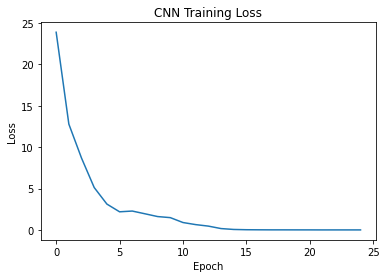

In [41]:
plt.plot(epoch_loss)
plt.title('CNN Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.savefig('./Training Loss.png')
plt.show()

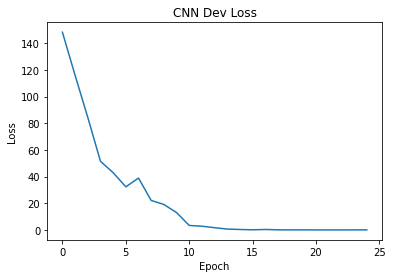

In [42]:
plt.plot(dev_epoch_loss)
plt.title('CNN Dev Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.savefig('./Dev Loss.png')
plt.show()

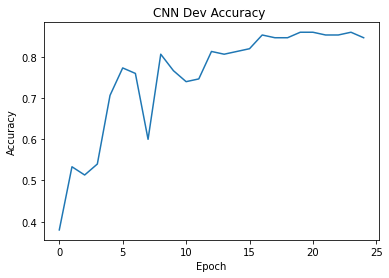

In [43]:
plt.plot(dev_accs)
plt.title('CNN Dev Accuracy ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.savefig('./Dev_Acc.png')
plt.show()

In [44]:
#train set performance
model.eval()
pred_train = []
lab_train = []
for data in evalloader:
    feature, label = data
    feature = feature.view(1,3,350,350)
    feature, label = feature.to(device),label.to(device)
    lab_train.append(label)
    pred_train.append(torch.argmax(model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else 
                                                      torch.cuda.FloatTensor))))

In [45]:
pred_train = np.array(pred_train)
lab_train = np.array(lab_train)
print("train set accuracy: " + str(np.sum(pred_train == lab_train) / len(lab_train)))

train set accuracy: 1.0


In [46]:
#dev set performance
pred_dev = []
lab_dev = []
for data in devloader:
    feature, label = data
    feature = feature.view(1,3,350,350)
    feature, label = feature.to(device),label.to(device)
    lab_dev.append(label)
    pred_dev.append(torch.argmax(model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor))))

In [52]:
pred_dev = np.array(pred_dev)
lab_dev = np.array(lab_dev)
print("dev set accuracy: " + str(np.sum(pred_dev == lab_dev) / len(lab_dev)))

dev set accuracy: 0.8466666666666667


In [48]:
#test set performance
pred_test = []
lab_test = []
for data in testloader:
    feature, label = data
    feature = feature.view(1,3,350,350)
    feature, label = feature.to(device),label.to(device)
    res = torch.argmax(model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor)))
    
    if not torch.cuda.is_available():
      lab_test.append(label)
      pred_test.append(res)
    else:
      lab_test.append(label.to('cpu'))
      pred_test.append(res.to('cpu'))
    
    


In [53]:
pred_test = np.array(pred_test)
lab_test = np.array(lab_test)
print("test set accuracy: " + str(np.sum(pred_test == lab_test) / len(lab_test)))

test set accuracy: 0.8466666666666667


In [50]:
torch.save(model,'./cnn_fin.pt')

In [51]:
conf_norm = normalize(confusion_matrix(lab_test,pred_test), norm="l1")
conf_norm = np.round(conf_norm, 2)
print(conf_norm)


[[0.93 0.   0.04 0.04 0.  ]
 [0.   0.78 0.15 0.02 0.05]
 [0.   0.09 0.77 0.05 0.09]
 [0.   0.   0.04 0.93 0.04]
 [0.03 0.06 0.06 0.   0.84]]


SVM confusion matrix for reference:
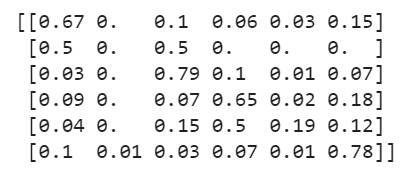

Expressions in order: anger, disgust, happiness, neutral, sadness, surprise
All of disgust was predicted as happiness??
Anger often confused with happiness and surprise
Happiness and neutral generally correct
Sadness usually predicted as neutral
Surprise ok, sometimes confused with anger and neutral

In [ ]:
print(classification_report(lab_test,pred_test))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        28
           1       0.94      0.78      0.85        41
           2       0.67      0.82      0.73        22
           3       0.92      0.86      0.89        28
           4       0.84      0.87      0.86        31

    accuracy                           0.85       150
   macro avg       0.84      0.85      0.84       150
weighted avg       0.86      0.85      0.85       150



In [ ]:
!cp ./cnn.pt drive/MyDrive/ML_Final/Models/Final_Models/